# Imports

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import gensim.downloader as api

# Data Loading

In [2]:
## Load cleaned data
X_reviews = pd.read_csv("/Users/egmac/code/arostagnat/BookMatch/data/proc_data/cluster_result/X_bert_cluster_200.csv")

In [3]:
## Load metadata
metadata_movies = pd.read_json("/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_movies/metadata.json", lines=True)
metadata_books = pd.read_json("/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_book/metadata.json", lines=True)

In [23]:
ratings_books =  pd.read_json("/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_book/ratings.json", lines=True)

In [24]:
ratings_books.head()

,item_id,user_id,rating
0,41335427,0,5
1,41335427,1,3
2,41335427,2,5
3,41335427,3,5
4,41335427,4,5


In [5]:
## Adjust import to replace $$$ with 0, and convert item_id to float to enable merge. 
## Note that the X_reviews import is preformatted as a float
# X_reviews = X_reviews.replace({'$$$': 0}, regex=False)
X_reviews.item_id_movie = X_reviews.item_id_movie.astype(float)
X_reviews.item_id_book = X_reviews.item_id_book.astype(float)

In [6]:
## Revise metadata item_id to float to match X_reviews
metadata_movies.item_id_movie = metadata_movies.item_id_movie.astype(float)
metadata_books.item_id_book = metadata_books.item_id_book.astype(float)

In [7]:
## Merge X_reviews and metadata
X_all = pd.merge(X_reviews, metadata_movies[["title_movie","item_id_movie"]], on="item_id_movie", how="left")
X_all = pd.merge(X_all, metadata_books[["title_book","item_id_book","url_book","img_book"]], on="item_id_book", how="left")

In [8]:
## Check import
X_all.head(1)

,item_id_movie,is_movie,item_id_book,clustering_label_bert,vector,title_movie,title_book,url_book,img_book
0,1.0,1.0,-1.0,41,"[-0.07900653034448624, -0.04929797351360321, 0...",Toy Story (1995),NaN,NaN,NaN


# Recommendation without clustering

In [9]:
## Import relevant packages

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
## Create extract of X_all with vectors spread across columns, and confirm relevance of dimensions
## Vectors have to be reformatted as lists, as they are formatted as strings with ""

vectors = X_all.vector.tolist()
vectors_revised = []

for vector in vectors:
    result = vector.strip('[]').replace("'","").replace(' ', '').split(',')
    result = [float(i) for i in result]
    vectors_revised.append(result)

X_vectors = pd.DataFrame(vectors_revised)

In [11]:
# svd = TruncatedSVD(n_components=X_vectors.shape[1])
# svd_result = svd.fit_transform(X_vectors)

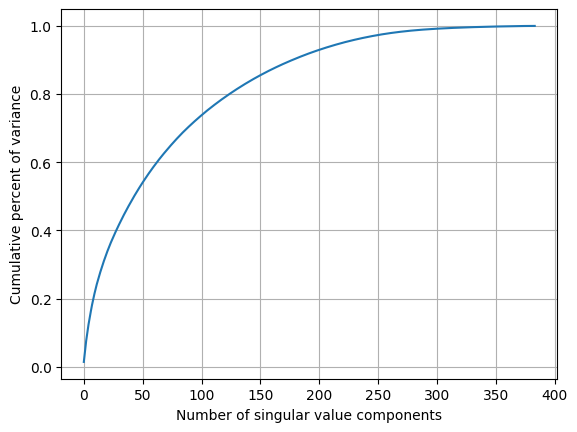

In [12]:
## Plot variance as a function of the number of components.
## Based on the below figure, nearly 100% of the variance is explained by 250 components
# plt.plot(svd.explained_variance_ratio_.cumsum())
# plt.xlabel('Number of singular value components')
# plt.ylabel('Cumulative percent of variance')   
# plt.grid()
# plt.show()

In [13]:
## Reshape vectors to 250 components, which will help reduce computational time
# n = 250
# X_vectors_revised = pd.DataFrame(X_vectors.iloc[:,0:n])
# print(f'X_all shape: {X_all.shape} | X_vectors shape: {X_vectors.shape} | X_vectors_revised shape: {X_vectors_revised.shape}')

X_all shape: (29322, 9) | X_vectors shape: (29322, 384) | X_vectors_revised shape: (29322, 250)


In [26]:
## Add qualitative columns to X_vectors_revised, and then create 2 separate dataframes for books and movies.
## Movie dataframe to be used to lookup user-inputted movies. Book dataframe to be used for calculations.
## Note that the dataframes need to be separated eventually, so it's worth doing now.

X_vectors[["item_id_movie","item_id_book","is_movie","clustering_label_bert"]] = X_all[["item_id_movie","item_id_book","is_movie","clustering_label_bert"]]

X_vectors_books = X_vectors[X_vectors.is_movie == 0].set_index("item_id_book",drop=True).drop(columns=["item_id_movie","is_movie"])
X_vectors_movies = X_vectors[X_vectors.is_movie == 1].set_index("item_id_movie",drop=True).drop(columns=["item_id_book","is_movie"])

In [255]:
## Input sample data
user_movies = [5816,40815,54001,69844]
## [5816,40815,54001,69844]

In [15]:
## Method 1: For each film in user list, calculate the cosine similarity with all books in the cluster
## Then, sort the books by their cosine similarity to identify **the** **closest** book for each film
## Finally, take the full list of book recommendations and then identify the **top 5 most frequent** books

def get_local_reccs(user_movies:list):
    
    verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
    
    recommendations = pd.DataFrame(columns=["similarity","title_book","img_book","url_book"])
    movies = pd.DataFrame(verified_movies,columns=["item_id_movie"])
    movies = pd.merge(movies,X_all[["title_movie","item_id_movie"]],on="item_id_movie",how="left")
    
    for movie_id in verified_movies:

        # Obtain vectors for user-inputted film and all books. Clusters are not used for time being
        ### movie_cluster = X_vectors_movies[X_vectors_movies.index == movie_id].cluster_bert.values[0]
        movie_vector = X_vectors_movies[X_vectors_movies.index == movie_id]
        books_vectors = X_vectors_books

        # Calculate cosine similarity
        sim_books = cosine_similarity(books_vectors,movie_vector)
 
        # Create summary table of books with their similarity and relevant details
        sim_books_detail = pd.DataFrame(sim_books,index=books_vectors.index,columns=["similarity"])
        sim_books_detail = sim_books_detail.sort_values("similarity",ascending=False)
        sim_books_detail = pd.merge(sim_books_detail,X_all[["title_book","img_book","url_book","item_id_book"]],
                                    on="item_id_book",how="left")

        # Add top book to recommendations dataframe
        top_book = pd.DataFrame([sim_books_detail.loc[0]])
        recommendations = pd.concat([recommendations,top_book],axis=0, ignore_index=True)
    
    print("Inputted films")
    print(movies)
    return recommendations["title_book"]


In [16]:
## Method 2: Calculate the average vector for all films in the user list, and then identify the corresponding cluster
## Then,calculate the cosine similarity with all books in the cluster
## Finally, sort the books by their cosine similarities and take the **top 5 closest** books

def get_global_reccs(user_movies:list):
    
    verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
    
    ## Collect vectors of all inputted films and calculate average vector
    movies_id = pd.DataFrame(verified_movies,columns=["item_id_movie"])
    movies_vectors = pd.merge(movies_id,
                              X_vectors_movies,
                              how="left",
                              on="item_id_movie").set_index("item_id_movie")
    avg_movie_vector = pd.DataFrame([movies_vectors.mean(numeric_only=True)])
    books_vectors = X_vectors_books

    ## Calculate cosine similarity
    sim_books = cosine_similarity(books_vectors,avg_movie_vector)

    ## Create summary table of books with their similarity and relevant details
    sim_books_detail = pd.DataFrame(sim_books,index=books_vectors.index,columns=["similarity"])
    sim_books_detail = sim_books_detail.sort_values("similarity",ascending=False)
    sim_books_detail = pd.merge(sim_books_detail,X_all[["title_book","img_book","url_book","item_id_book"]],on="item_id_book",how="left")
    
    ## Take top 5 books and show results
    recommendations = sim_books_detail.head(5)
    movie_titles = pd.merge(movies_id,X_all[["title_movie","item_id_movie"]],how="inner",on="item_id_movie")
    print("Inputted films")
    print(movie_titles.title_movie)
    print ("Top 5 book recommendations")
    return recommendations["title_book"]

# Recommendation with clustering

In [34]:
def get_local_reccs_cluster(user_movies:list):
    
    verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
    
    recommendations = pd.DataFrame(columns=["similarity","title_book","img_book","url_book"])
    movies = pd.DataFrame(verified_movies,columns=["item_id_movie"])
    movies = pd.merge(movies,X_all[["title_movie","item_id_movie"]],on="item_id_movie",how="left")
    
    for movie_id in verified_movies:

        # Obtain vectors for user-inputted film and all books.
        movie_cluster = X_vectors_movies[X_vectors_movies.index == movie_id].clustering_label_bert.values[0]
        movie_vector = X_vectors_movies[X_vectors_movies.index == movie_id].drop(columns=["clustering_label_bert"])
        books_vectors = X_vectors_books[X_vectors_books.clustering_label_bert == movie_cluster].drop(columns=["clustering_label_bert"])

        # Calculate cosine similarity
        sim_books = cosine_similarity(books_vectors,movie_vector)
 
        # Create summary table of books with their similarity and relevant details
        sim_books_detail = pd.DataFrame(sim_books,index=books_vectors.index,columns=["similarity"])
        sim_books_detail = sim_books_detail.sort_values("similarity",ascending=False)
        sim_books_detail = pd.merge(sim_books_detail,X_all[["title_book","img_book","url_book","item_id_book"]],
                                    on="item_id_book",how="left")

        # Add top book to recommendations dataframe
        top_book = pd.DataFrame([sim_books_detail.loc[0]])
        recommendations = pd.concat([recommendations,top_book],axis=0, ignore_index=True)
    
    print("Inputted films")
    print(movies)
    return recommendations["title_book"]


In [72]:
def get_global_reccs_cluster(user_movies:list):
    
    verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
    
    ## Collect vectors of all inputted films and calculate average vector
    movies_id = pd.DataFrame(verified_movies,columns=["item_id_movie"])
    movies_vectors = pd.merge(movies_id,
                              X_vectors_movies,
                              how="left",
                              on="item_id_movie").set_index("item_id_movie")
    avg_movie_vector = pd.DataFrame([movies_vectors.mean(numeric_only=True)]).drop(columns=["clustering_label_bert"])
    all_movies_vectors = X_vectors_movies.drop(columns=["clustering_label_bert"])
    
    ## Find cluster of nearest item (film)
    sim_movies = cosine_similarity(all_movies_vectors,avg_movie_vector)
    sim_movies_detail = pd.DataFrame(sim_movies,
                                     index=X_vectors_movies.index,
                                     columns=["similarity"]).sort_values("similarity",ascending=False).reset_index()
    closest_movie_id = sim_movies_detail.loc[0].item_id_movie
    closest_cluster = X_vectors_movies[X_vectors_movies.index == closest_movie_id].clustering_label_bert.values[0]
    books_vectors = X_vectors_books[X_vectors_books.clustering_label_bert== closest_cluster].drop(columns=["clustering_label_bert"])

    ## Calculate cosine similarity
    sim_books = cosine_similarity(books_vectors,avg_movie_vector)

    ## Create summary table of books with their similarity and relevant details
    sim_books_detail = pd.DataFrame(sim_books,index=books_vectors.index,columns=["similarity"])
    sim_books_detail = sim_books_detail.sort_values("similarity",ascending=False)
    sim_books_detail = pd.merge(sim_books_detail,X_all[["title_book","img_book","url_book","item_id_book"]],on="item_id_book",how="left")
    
    ## Take top 5 books and show results
    recommendations = sim_books_detail.head(5)
    movie_titles = pd.merge(movies_id,X_all[["title_movie","item_id_movie"]],how="inner",on="item_id_movie")
    print("Inputted films")
    print(movie_titles.title_movie)
    print ("Top 5 book recommendations")
    return recommendations["title_book"]

# Example results

In [17]:
get_local_reccs([1,2,3,4,5,6,7])

Inputted films
   item_id_movie                         title_movie
0              1                    Toy Story (1995)
1              2                      Jumanji (1995)
2              3             Grumpier Old Men (1995)
3              4            Waiting to Exhale (1995)
4              5  Father of the Bride Part II (1995)
5              6                         Heat (1995)
6              7                      Sabrina (1995)


0                                      After the Quake
1                                The Phantom Tollbooth
2                                                Congo
3    Girls in Pants: The Third Summer of the Sister...
4                                             Shopgirl
5                              Cross (Alex Cross, #12)
6                                        Twelfth Night
Name: title_book, dtype: object

In [73]:
get_global_reccs_cluster([1,2,3,4,5,6,7])

ValueError: Found array with 0 sample(s) (shape=(0, 384)) while a minimum of 1 is required by check_pairwise_arrays.

In [35]:
get_local_reccs_cluster([1,2,3,4,5,6,7])

ValueError: Found array with 0 sample(s) (shape=(0, 384)) while a minimum of 1 is required by check_pairwise_arrays.

In [75]:
user_movies = [1,2,3,4,5,6,7]
verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
movies_id = pd.DataFrame(verified_movies,columns=["item_id_movie"])
movies_vectors = pd.merge(movies_id,
                          X_vectors_movies,
                          how="left",
                          on="item_id_movie").set_index("item_id_movie")
avg_movie_vector = pd.DataFrame([movies_vectors.mean(numeric_only=True)])
books_vectors = X_vectors_books

In [18]:
get_global_reccs([1,2,3,4,5,6,7])

Inputted films
0                      Toy Story (1995)
1                        Jumanji (1995)
2               Grumpier Old Men (1995)
3              Waiting to Exhale (1995)
4    Father of the Bride Part II (1995)
5                           Heat (1995)
6                        Sabrina (1995)
Name: title_movie, dtype: object
Top 5 book recommendations


0                            The Giver (The Giver, #1)
1                            Honeymoon (Honeymoon, #1)
2                             Like Water for Chocolate
3    Forever in Blue: The Fourth Summer of the Sist...
4                                We Were the Mulvaneys
Name: title_book, dtype: object

In [99]:
metadata_movies.head(10)

,title_movie,directedBy,starring,dateAdded,avgRating,imdbId,item_id_movie
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",None,3.89146,114709,1.0
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",None,3.26605,113497,2.0
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",None,3.17146,113228,3.0
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",None,2.86824,114885,4.0
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",None,3.07620,113041,5.0
5,Heat (1995),Michael Mann,"Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...",None,3.85549,113277,6.0
6,Sabrina (1995),Sydney Pollack,"Harrison Ford, Greg Kinnear, Nancy Marchand, J...",None,3.37244,114319,7.0
7,Tom and Huck (1995),Peter Hewitt,"Jonathan Taylor Thomas, Brad Renfro, Eric Schw...",None,3.11678,112302,8.0
8,Sudden Death (1995),Peter Hyams,"Raymond J. Barry, Powers Boothe, Jean-Claude V...",None,3.00242,114576,9.0
9,GoldenEye (1995),Martin Campbell,"Pierce Brosnan, Sean Bean, Famke Janssen, Izab...",None,3.43340,113189,10.0


In [104]:
movies_titles = ["Toy Story (1995)","Jumanji (1995)","Grumpier Old Men (1995)"]

In [112]:
movie_ids = [metadata_movies[metadata_movies.title_movie == title].item_id_movie.values[0] for title in movies_titles]

In [113]:
movie_ids

[1.0, 2.0, 3.0]